In [222]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

## choose file with the run number

In [296]:
pgroup='p21005'
runnumber = 305
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0305


'/sf/alvra/data/p21005/raw/run0305-N4PY_time_7123_6uJ_003/meta/scan.json'

In [297]:
quantile_corr = 0.5

Timezero_mm = 199.38 ## this in mm from the timescans 5.12 - 06:50 night

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'
saveflag=True

#######################################################################################################33
from sfdata import SFScanInfo
try:
    scan = SFScanInfo(jsonfile)
    scan = remove_JF_from_scan(scan)
    flag = False

    try:
        flag = True
        Timezero_mm = get_timezero_NBS(jsonfile)
    except:
        Timezero_mm = Timezero_mm

    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, readbacks, goodshots) = \
    XAS_scanPP_1diode_noTT(scan, detector_XAS, detector_Izero, quantile_corr)


    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

    Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)
    #Delay_fs = Delay_fs[:len(readbacks)]
    if saveflag:
        os.makedirs(reducedir+run_name, exist_ok=True)
        save_data_timescans(reducedir, run_name, Delay_mm, Delay_fs,
                            DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, goodshots)
except:
    print ('==> json file not yet ready!! <==')


Processing: run0305-N4PY_time_7123_6uJ_003
Step 76 of 76: Processing acq0076

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY    1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 494 pump and 494 unpump shots
(123,) shots out of (494,) survived
Step 76 of 76: Processed acq0076
correlation Diode (all shots) = 0.9891500928747425
------------------------------
Processed 76 out of 76 files
------------------------------
Timezero found in file = 160.32822000004498 mm
Scan is done with the stage in fs


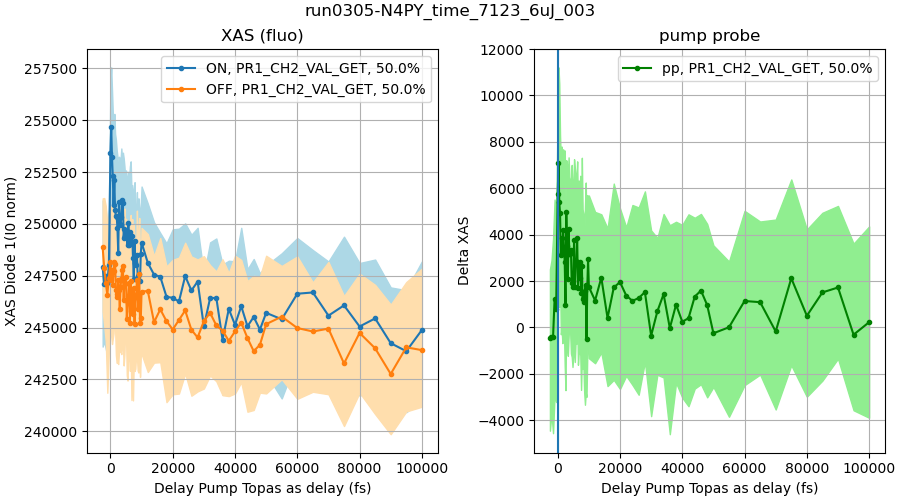

In [298]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

#XAS_pump_probe = XAS_pump_probe- np.mean(XAS_pump_probe[:3])
#XAS_pump = XAS_pump- np.mean(XAS_pump[:3])
XAS_unpump = XAS_unpump#- np.mean(XAS_unpump[:5])

ax1.plot(Delay_fs, XAS_pump, label='ON, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS_unpump, label='OFF, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS_pump_probe, label='pp, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(Delay_fs, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()
ax2.axvline(0)
plt.show()

## Check correlation for a certain delay point

In [265]:
chosen_delay_fs = 500

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110
quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))
print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(167,) shots out of (490,) survived
Correlation (all shots)      = 0.9899922459963053
Correlation (filtered shots) = 0.9983471718211142
Delay = 748.00 fs


In [245]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 265197.8039439655, Median (filtered) = 264830.8308669053
MAD (all) = 10203.241039716271, MAD(filtered) = 5518.46350661926
MAD/median (all) = 3.8474078170994757%, MAD/median (filtered) = 2.0837692834157395%


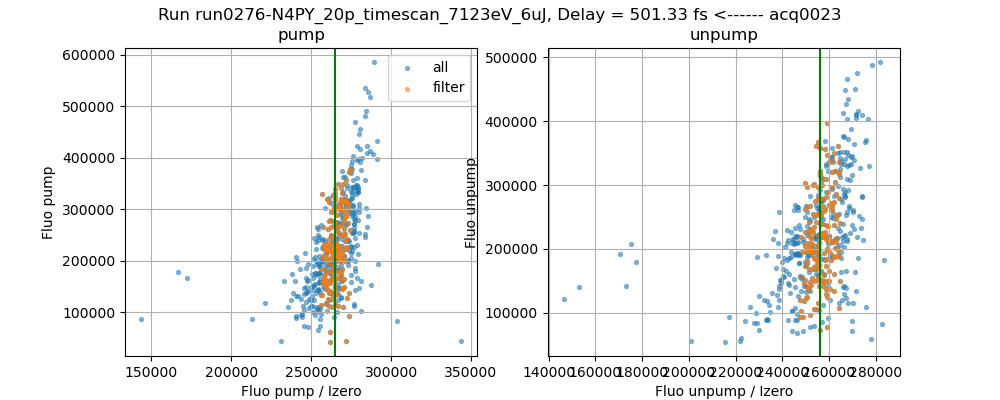

In [246]:
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.legend(loc='best')
plt.xlabel('Fluo pump / Izero')
plt.ylabel('Fluo pump')
plt.grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

plt.subplot(122)
plt.title('unpump')
plt.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.xlabel('Fluo unpump / Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

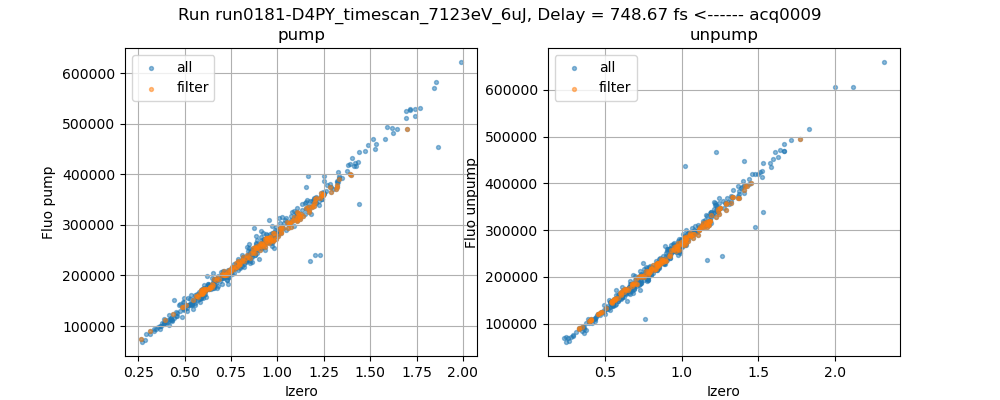

In [264]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump, Fluo_pump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump, Fluo_unpump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [239]:
pgroup='p20269'
runlist = [276,289]
#runlist = np.arange(176, 179, 1)

print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

2 runs: [276, 289]


['/sf/alvra/data/p20269/raw/run0276-PtSPh_timescan_11560eV_3uJ/meta/scan.json',
 '/sf/alvra/data/p20269/raw/run0289-mono_scan/meta/scan.json']

In [240]:
quantile_corr = 0.6
Timezero_mm = 86.61422    ## this in mm from the YAG scans

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans_test/'

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []
Delay_fs_all = []

for json_file in jsonlist:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    flag = False
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs, goodshots) = \
    XAS_delayscan_noTT(scan, detector_XAS, detector_Izero, quantile_corr)
    
    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)
    Delay_fs_all.append(Delay_fs)
    
    run_name = json_file.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    
    save_data_timescans(reducedir, run_name, Delay_mm, Delay_fs,
                        DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, goodshots)
    
    print ('Processed run {}'.format(json_file.split('/')[-3]))

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)


NameError: name 'XAS_delayscan_noTT' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(jsonlist))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(jsonlist))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(jsonlist))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(jsonlist))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]/np.sqrt(len(jsonlist))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]/np.sqrt(len(jsonlist))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
#ax2.fill_between(Delay_fs_mean, XAS_pump_probe - err_low_pump_probe, XAS_pump_probe + err_high_pump_probe, color='lightgreen')


ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()